# Evolutionary Algorithms

In [1]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# game configuration
grid_size = 20         # length of the game board including a border of 1
population_size = 30  # number of creatures
life_time = 30          # number of steps per generation
mutation_rate = 0.1   # probability of that one the weights get mutated

In [3]:
n_actions = 4       # a creature can move into four directions 
n_observations = 8  # it observes the 8 adjacent squares around it

class Creature():
    # map directions to places in observation space
    posmap = {0:-grid_size, # up
              1:1,          # right
              2:grid_size,  # down
              3:-1}         # left
    
    def __init__(self):
        self.pos = 0 # the ceratures current position on the grid, will be set later
        self.genes = np.random.normal(size=n_actions*n_observations)

    def observations(self, state):
        # we observe the space around our current position
        p = self.pos
        obs = state[p-1-grid_size:p+2-grid_size]
        obs += [state[p-1]] + [state[p+1]] 
        obs += state[p-1+grid_size:p+2+grid_size]
        return obs
        
    def get_move(self, state):
        brain = self.genes.reshape((n_actions,n_observations))
        
        # neural network prediction
        x = brain.dot(self.observations(state))
        direction = np.argmax(x*(x>0))
        
        old_pos = self.pos
        new_pos = self.pos + self.posmap[direction]
        
        # we only move if the destination is empty
        if state[new_pos]==0:
            self.pos = new_pos 
        return old_pos, self.pos   

In [4]:
# Start a new game        
# by creating new creatures 
lCreatures = [Creature() for _ in range(population_size)]

In [5]:
def new_generation():
    global state, lCreatures
        
    # create the gid world state
    state, lfield = [], []
    for i in range(grid_size**2):
        if i%grid_size in [0,grid_size-1]:
            state.append(1)        
        elif i<grid_size or i>(grid_size**2-grid_size):
            state.append(1)
        else:
            state.append(0)
            lfield.append(i)
            
    # select random locations on the field (no duplicates)
    lpos = random.sample(lfield, population_size) 
    state = [1 if i in lpos else state[i] for i in range(len(state))]
    
    # place ceatures at new positions 
    for c,p in zip(lCreatures,lpos):
        c.pos = p

In [6]:
# Test if our state generation worked
new_generation()
sum(state)

106

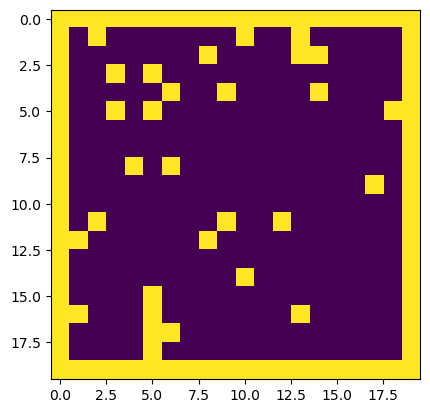

In [7]:
# This is an example of a random starting position (generated by new_generation())
plt.imshow(np.array(state).reshape(grid_size,-1));

In [8]:
# no selection
def selection(lCreatures):
    return lCreatures

In [9]:
# selection in of smaller position values
def selection(lCreatures):
    return [c for c in lCreatures if c.pos<grid_size**2//2]

In [10]:
# --->>> Your turn <<<---
# a) Play with the parameters:
# - grid_size
# - population_size
# - life_time
# - mutation_rate
# What do you observe?
# 
# b) Create another selection() function and experiment with it.

In [11]:
def evolve(n_generations=1):
    global state, lCreatures
    
    for _ in range(n_generations):
        new_generation() # reset starting positions
        lstates = []

        for _ in range(life_time):
            
            # update all Creatures in random order
            for i in random.sample(range(population_size),population_size):
                old_pos, new_pos = lCreatures[i].get_move(state)
                state[old_pos] = 0
                state[new_pos] = 1                
            
            # save an image of the current grid world state
            lstates.append(np.array(state).reshape(grid_size,-1))
        
        # survival of the fittest
        lCreatures = selection(lCreatures)
        if len(lCreatures)==0: 
            print('no survivors!')
            return
        
        # create new children
        while(len(lCreatures)<population_size):
            c = random.choice(lCreatures)
            c_new = copy.deepcopy(c)
            if random.random()<mutation_rate:
                c_new.genes[random.randrange(0, len(c_new.genes)-1)] = np.random.normal()
            lCreatures.append(c_new)
            
    return lstates

In [12]:
lstates = evolve(10)

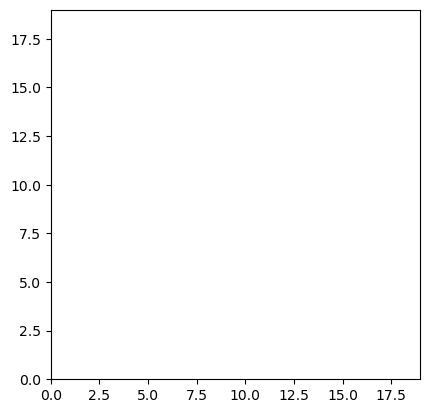

In [13]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_xlim(( 0, grid_size-1))
ax.set_ylim(( 0, grid_size-1))
f = ax.imshow(np.zeros((0,0)))

# initialization function: plot the background of each frame
def init():
    f.set_data(np.zeros((0,0)))
    return (f,)

def animate(i):
    ax.imshow(lstates[i])
    return (f,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(lstates), interval=200, blit=True)

In [14]:
HTML(anim.to_jshtml())